## Escola Piloto Virtual - PEQ/COPPE/UFRJ
## Data Science e Machine Learning na Prática - Introdução e Aplicações na Indústria de Processos

Este notebook é referente à aula 5 do curso e trata de três técnicas importantes que não foram utilizadas nos estudos de caso das aulas anteriores:

* [Validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html);
* [Curvas de aprendizado](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning));
* [Sintonização de hiperparâmetros](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

In [1]:
# importando os principais módulos que usaremos ao longo da aula

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn.datasets
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.model_selection
import sklearn.metrics

import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.neighbors

from tensorflow import keras

import optuna

In [2]:
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(keras.__version__)
print(optuna.__version__)

1.18.5
1.1.3
3.2.1
0.23.2
2.4.0
2.2.0


# Videoaula

Este notebook é explicado em detalhes ao longo da seguinte videoaula:

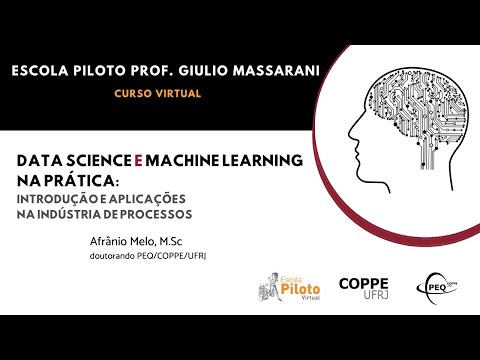

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("w0NDlRuTkVw")

Para a playlist do curso completo, clique [aqui](https://www.youtube.com/playlist?list=PLvr45Arc0UpzsRhzq3q4_KmZcm0utwvvB).

# Validação cruzada

A [validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html) é uma estratégia para atenuar o efeito da arbitrariedade da escolha do conjunto de validação. A ideia básica é efetuar várias rodadas de treinamento de modo que todas as amostras sejam utilizadas tanto para treinamento quanto para validação. É particularmente útil quando o conjunto de dados é pequeno, já que reduz o ruído de amostragem.

Existem diversos tipos de validação cruzada. Aqui será descrita a validação $k$-fold, em que:

1. divide-se aleatoriamente o conjunto de treinamento em $k$ conjuntos mutuamente exclusivos e do mesmo tamanho;
2. realizam-se $k$ treinamentos, cada um deles utilizando para validação um dos $k$ conjuntos definidos na etapa 1.

A figura a seguir ilustra bem a validação $k$-fold:

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg" width="600" height="600"/>

A validação $k$-fold só é aplicável a conjuntos compostos por amostras [independentes e identicamente distribuídas](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables).

Lembrando que é boa prática manter um conjunto de teste separado para que seja usado apenas ao final da modelagem (ou seja, após todas as eventuais rodadas de validação cruzada), como uma "prova final".

Ilustraremos a validação cruzada utilizando o conjunto de dados `digits`, disponível nativamente no módulo `sklearn.datasets`. É uma espécie de versão reduzida do [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

In [4]:
digits = sklearn.datasets.load_digits()

X, y = digits.data, digits.target

#normalizando os pixels
X = X/256

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Separando em treino/teste:

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                            test_size=0.2, 
                                                                            random_state=0)

Os dados `X_train` e `y_train` serão usados para efetuar a validação cruzada, enquanto `X_test` e `y_test` são reservados para um teste final.

Na próxima célula, instanciaremos um modelo simples conhecido como [regressão logística](https://en.wikipedia.org/wiki/Logistic_regression). Apesar do nome enganoso, o modelo serve para problemas de *classificação*, não de regressão. É equivalente a uma rede neural sem camadas ocultas composta de um único neurônio com função de ativação logística na camada de saída.

In [6]:
m = sklearn.linear_model.LogisticRegression(penalty='none', max_iter = 200)

Para esse estudo de caso, a regressão logística sem regularização tem melhor desempenho. Por isso, o argumento `penalty` foi especificado como `none`.

Abaixo efetuamos a validação cruzada. Para tal, a função [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) aceita um modelo, os dados `X` e `y` e a métrica de avaliação:

In [7]:
results = sklearn.model_selection.cross_val_score(m, X_train, y_train, scoring='accuracy')
results

array([0.95486111, 0.93402778, 0.96515679, 0.95818815, 0.97212544])

A validação $k$-fold foi efetuada com $k=5$, o default da função `cross_val_score`, o que pode ser modificado por meio do fornecimento de um argumento adicional `cv`.

As acurácias variam bastante de iteração para iteração. Isso indica que a escolha do conjunto de validação, nesse caso, influencia o resultado. Para uma métrica global menos dependente dessa escolha, podemos tirar a média das $k$ iterações:

In [8]:
results.mean()

0.9568718544328301

## Comparando modelos

A validação cruzada é particularmente adequada para uma comparação justa entre os desempenhos de vários modelos (de naturezas diferentes, ou um mesmo modelo com diferentes hiperparâmetros).

Abaixo, calculamos os desempenhos de vários modelos utilizando a validação cruzada:

Modelo: média, desvio-padrão
-------------------
LogisticRegression: 0.876, 0.034
DecisionTreeClassifier: 0.852, 0.0233
RandomForestClassifier: 0.976, 0.0118
GradientBoostingClassifier: 0.958, 0.0171
KNeighborsClassifier: 0.987, 0.0101
LinearSVC: 0.93, 0.0229
SVC: 0.987, 0.00729


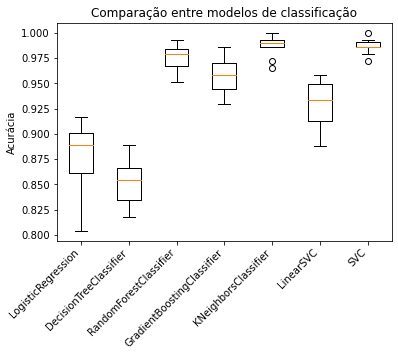

In [9]:
# especificando modelos 

modelos = [
    
    sklearn.linear_model.LogisticRegression(),
    sklearn.tree.DecisionTreeClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.ensemble.GradientBoostingClassifier(),
    sklearn.neighbors.KNeighborsClassifier(),
    sklearn.svm.LinearSVC(),
    sklearn.svm.SVC()  
    
]

#lista para guardar resultados
results = [0]*len(modelos)

print('Modelo: média, desvio-padrão\n-------------------')

for i in range(len(modelos)):
    
    # efetuando a validação cruzada!
    results[i] = sklearn.model_selection.cross_val_score(modelos[i], 
                                                         X_train, y_train, 
                                                         cv=10, 
                                                         scoring='accuracy',
                                                         n_jobs=-1)
    
    # imprimindo resultados
    print(f'{modelos[i].__class__.__name__}: {results[i].mean():.3}, {results[i].std():.3}')

# plotando resultados
fig, ax = plt.subplots()
ax.boxplot(results)

# formatando gráfico
ax.set_xticklabels([modelos[i].__class__.__name__ for i in range(len(modelos))], 
                   rotation = 45, ha="right")
ax.set_ylabel("Acurácia")
ax.set_title('Comparação entre modelos de classificação');

* O gráfico acima é um [diagrama de caixa](https://pt.wikipedia.org/wiki/Diagrama_de_caixa), em que os dados são apresentados da seguinte maneira:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Elements_of_a_boxplot_pt.svg/1280px-Elements_of_a_boxplot_pt.svg.png" width="400" height="400"/>

* Os melhores modelos foram [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) e [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

* Aplicando os modelos no conjunto de teste:

In [10]:
print('Acurácias\n--------------')

for m in modelos:
    m.fit(X_train, y_train)
    print(f'{m.__class__.__name__}: {sklearn.metrics.accuracy_score(y_test, m.predict(X_test)):.3}')

Acurácias
--------------
LogisticRegression: 0.864
DecisionTreeClassifier: 0.842
RandomForestClassifier: 0.969
GradientBoostingClassifier: 0.964
KNeighborsClassifier: 0.975
LinearSVC: 0.931
SVC: 0.992


Considerando o treinamento com a a totalidade do conjunto `X_train, y_train` e usando apenas o conjunto de teste para avaliação, o modelo `SVC` se destaca ainda mais.

Em todos os modelos, os hiperparâmetros utilizados foram os default especificados pelo `scikit-learn`. Mas essa comparação não é totalmente justa: sabemos, por exemplo, que a regressão logística sem regularização tem resultado melhor neste caso do que o default (com regularização $L_2$).

Para investigar mais a fundo as diferenças entre os modelos, é útil analisar como os seguintes efeitos afetam os desempenhos:

* o tamanho do conjunto de treinamento; 
* as diversas combinações de hiperparâmetros.

Esses serão os temas das duas próximas seções.

# Curvas de aprendizado

[Curvas de aprendizado](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) exibem a relação entre o desempenho de um modelo e o número de amostras do conjunto de treinamento.

Abaixo utilizamos a função [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) para plotar as curvas de aprendizado dos modelos analisados na seção anterior. Cada ponto em uma curva resulta de um procedimento de validação cruzada.

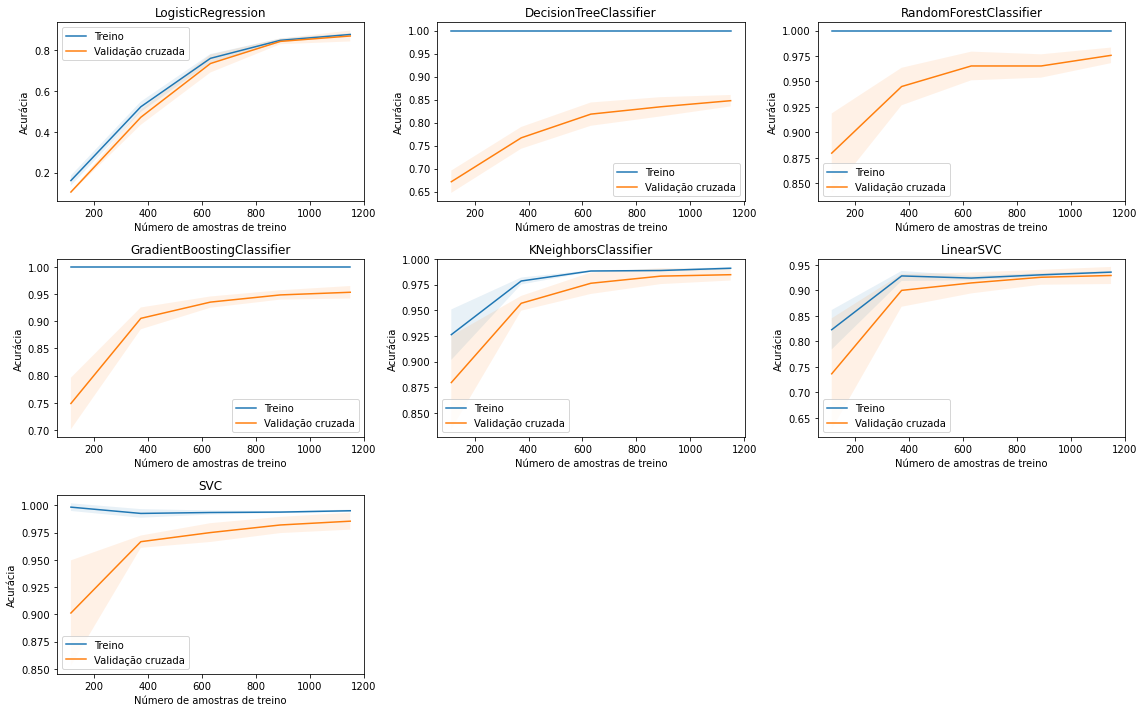

In [11]:
# adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

# especificando modelos 

modelos = [
    
    sklearn.linear_model.LogisticRegression(),
    sklearn.tree.DecisionTreeClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    sklearn.ensemble.GradientBoostingClassifier(),
    sklearn.neighbors.KNeighborsClassifier(),
    sklearn.svm.LinearSVC(),
    sklearn.svm.SVC()  
    
]

fig, ax = plt.subplots(3,3,figsize=(16,10))

for i in range(len(modelos)):
    
    # calculando a curva de aprendizado!
    train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(modelos[i], 
                                                                                    X_train, y_train, 
                                                                                    cv=5, 
                                                                                    scoring='accuracy',
                                                                                    n_jobs=-1)
    
    # médias e desvios-padrão dos resultados da validação cruzada (para cada ponto da curva)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # plotando curva correspondente ao treino
    ax.ravel()[i].plot(train_sizes, train_scores_mean, label="Treino")
    ax.ravel()[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1)
    
    # plotando curva correspondente ao teste
    ax.ravel()[i].plot(train_sizes, test_scores_mean, label="Validação cruzada")
    ax.ravel()[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1)
    
    # formatando gráfico
    ax.ravel()[i].set_title(modelos[i].__class__.__name__)
    ax.ravel()[i].set_ylabel('Acurácia')
    ax.ravel()[i].set_xlabel('Número de amostras de treino')
    ax.ravel()[i].legend(loc="best")
    
ax.ravel()[-2].axis('off')
ax.ravel()[-1].axis('off')

fig.tight_layout();

* A curva de aprendizado possibilita que verifiquemos os graus de sobreajuste dos modelos. Os modelos baseados em árvore (`DecisionTree`, `RandomForest` e `GradientBoosting`), por exemplo, sobreajustam bastante, ainda que atinjam resultados bons (principalmente os dois últimos). Já a regressão logística apresenta baixíssimo sobreajuste.

* Um platô ao final da curva indica que o modelo não se beneficiaria muito da adição de dados no conjunto de treinamento (ao contrário de modelos que apresentem tendência mais crescente).

# Sintonização de hiperparâmetros

[Sintonização de hiperparâmetros](https://en.wikipedia.org/wiki/Hyperparameter_optimization) é o procedimento de ajustar os hiperparâmetros de um modelo de modo a maximizar sua capacidade de generalização.

Nas últimas aulas efetuamos alguns exercícios de sintonização manual. Nessa estratégia, nós, seres humanos, avaliamos por tentativa e erro algumas combinações de hiperparâmetros que nossas intuições indicam ser razoáveis. É uma estratégia simples, mas muito usada na prática, já que a intuição é uma importante característica humana que as máquinas (ainda) não possuem.

Uma maneira simples de incrementar essa intuição é visualizando algumas *curvas de validação*.

## Curvas de validação

[Curvas de validação](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) exibem a relação entre desempenho do modelo e algum hiperparâmetro selecionado.

Na célula abaixo, é plotada a curva de validação para o modelo `LogisticRegression` em relação ao hiperparâmetro `C` no conjunto `digits`:

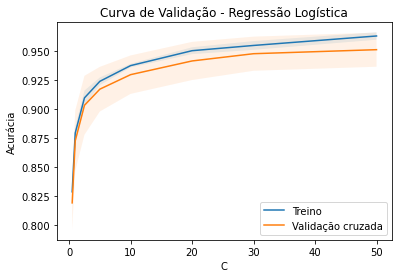

In [12]:
# adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

# definindo os valores de parâmetros a serem testados
param_range = [0.5, 1, 2.5, 5, 10, 20, 30, 50]

# definindo o modelo
m = sklearn.linear_model.LogisticRegression(max_iter=200)

# calculando a curva de validação!
train_scores, test_scores = sklearn.model_selection.validation_curve(m, X_train, y_train, 
                                                                     param_name="C", 
                                                                     param_range=param_range,
                                                                     scoring="accuracy", 
                                                                     n_jobs=-1)

# médias e desvios-padrão dos resultados da validação cruzada (para cada ponto da curva)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plotando curva correspondente ao treino
plt.plot(param_range, train_scores_mean, label="Treino")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)

# plotando curva correspondente ao teste
plt.plot(param_range, test_scores_mean, label="Validação cruzada")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)

# formatando gráfico
plt.title("Curva de Validação - Regressão Logística")
plt.xlabel('C')
plt.ylabel("Acurácia")
plt.legend(loc="best");

* Lembre-se de que o hiperparâmetro `C` indica o inverso da força da regularização. Portanto, quanto maior o valor de `C`, menos regularizado é o modelo. A figura acima indica que os resultados melhoram conforme se aumenta `C`. Ao analisá-la, uma analista chegaria à conclusão de que é melhor não aplicar regularização e especificaria o hiperparâmetro `penalty = 'none'`. 

* Como as curvas são próximas em toda a extensão do gráfico, podemos concluir que o grau de sobreajuste não é significativo (por isso a regularização não ajuda, já que ela é uma estratégia justamente para diminuir sobreajuste).

* Para baixos valores de `C`, tanto as métricas de treino quanto de validação têm valores baixos, o que caracteriza *subajuste*. 

* Tome cuidado: quando há mais de um hiperparâmetro a ser ajustado, a análise do efeito de apenas um deles pode ser enganosa, já que a relação expressa em uma curva de validação pode ser completamente diferente para outras combinações dos demais hiperparâmetros. De qualquer forma, trata-se de uma ferramenta útil para verificar faixas hiperparamétricas em que possa ocorrer subajuste e sobreajuste.

**Mão na massa 1!**

* Escolha um problema de regressão de sua preferência (você pode procurar no [Kaggle](https://www.kaggle.com/datasets), [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html), [UCI Repository](https://archive.ics.uci.edu/ml/index.php), usar algum relacionado a seu trabalho, etc.) e reproduza os procedimentos apresentados acima:
    * Comparação em diagrama de caixa entre vários modelos, utilizando validação cruzada;
    * Traçado de curvas de aprendizado para os vários modelos;
    * Traçado de curvas de validação para hiperparâmetro(s) selecionado(s).

Dica: por conta da natureza do problema (regressão e não mais classificação), você precisará utilizar outros modelos e métricas de avaliação.

## Sintonização automática

Para demonstrar a sintonização automática de hiperparâmetros, utilizaremos o [conjunto de dados Iris de Fisher](https://pt.wikipedia.org/wiki/Conjunto_de_dados_flor_Iris) (já conhecido de um exercício da [Aula 2](https://www.kaggle.com/afrniomelo/epv-peq-aula-2-detec-o-de-falhas)):

In [13]:
dataset = sklearn.datasets.load_iris()

X, y = dataset.data, dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Separando em treino/teste:

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                            test_size=0.1, 
                                                                            random_state=0)

Para efetuar a sintonização, é comum que se utilize uma das classes do módulo [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) para otimização de hiperparâmetros: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) ou [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). A primeira efetua uma busca exaustiva ao longo de todas as combinações de possíveis hiperparâmetros especificados pelo usuário. A segunda é parecida, porém a busca é feita com apenas algumas combinações selecionadas aleatoriamente. Ambas utilizam validação cruzada para análise de desempenho (por isso `CV` ao final do nome).

As duas classes descritas são úteis, mas não fornecem uma estratégia inteligente de busca: simplesmente avaliam algumas combinações e indicam qual forneceu o melhor resultado.

Nesta aula, utilizaremos a biblioteca [Optuna](https://optuna.org/), que implementa algoritmos de [otimização bayesiana](https://en.wikipedia.org/wiki/Bayesian_optimization) para estratégias inteligentes e eficientes de exploração do espaço de busca. Na otimização bayesiana, constrói-se um modelo de probabilidades para a função objetivo e esse modelo é usado para estimar as combinações de hiperparâmetros mais promissoras. Para detalhes, cheque [AKIBA *et al.* (2019)](https://arxiv.org/abs/1907.10902).

Para utilizar a `Optuna`, o primeiro passo é definir uma função objetivo que efetue o treinamento e retorne uma medida de desempenho a ser maximizada. Não necessariamente o treinamento precisa ficar restrito a um único modelo: podemos avaliar vários modelos, inclusive de bibliotecas diferentes. 

Na função objetivo abaixo, dois modelos são avaliados em uma mesma otimização: florestas aleatórias do `scikit-learn` e redes neurais MLP do `keras`.

In [15]:
# função objetivo para otimização de hiperparâmetros
def objetivo(trial):

    # colocaremos dois modelos pra brigar: MLP e RF
    classifier_name = trial.suggest_categorical("classifier", ["MLP", "RandomForest"])
    
    if classifier_name == 'MLP':
        
        # hiperparâmetros de busca para o MLP
        mlp_hidden_size = trial.suggest_int("mlp_hidden_size", 2,400)
        mlp_lr = trial.suggest_float("mlp_lr", 1e-3, 2e-1, log = True)
        mlp_momentum = trial.suggest_float("mlp_momentum", 0.8, 1, log = True)
        mlp_batch_size = trial.suggest_int("mlp_batch_size", 8, 32)
        
        # montando a rede MLP
        def m_keras():

            m_keras = keras.models.Sequential()
            m_keras.add(keras.layers.Dense(mlp_hidden_size, 
                                           activation = 'relu', 
                                           input_dim = X_train.shape[1]))
            m_keras.add(keras.layers.Dense(dataset.target_names.shape[0], 
                                           activation = 'softmax'))
            sgd = keras.optimizers.SGD(lr = mlp_lr, 
                                       momentum = mlp_momentum, 
                                       nesterov = True)
            m_keras.compile(optimizer=sgd,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
            
            return m_keras
        
        # modelo MLP
        
        # wrapper para adequar o modelo keras à interface do sklearn
        mlp = keras.wrappers.scikit_learn.KerasClassifier(m_keras, 
                                                          epochs = 50, 
                                                          batch_size = mlp_batch_size)
        
        # montando uma pipeline com pré-processamento+modelo
        m = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()), 
                                       ('mlp', mlp)])
        
    else:

        # hiperparâmetros de busca para o RF
        rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log = True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10,100)
        
        # modelo RF
        m = sklearn.ensemble.RandomForestClassifier(max_depth = rf_max_depth, 
                                                    min_samples_leaf = rf_min_samples_leaf, 
                                                    n_estimators = rf_n_estimators)

    # retornando acurácia
    acuracias = sklearn.model_selection.cross_val_score(m, X_train, y_train, n_jobs = -1, cv = 3)
    acuracia = acuracias.mean()
    return acuracia

* O argumento da função objetivo deve ser um objeto da classe [Trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial), responsável por fornecer sugestões de parâmetros, dentre outras tarefas.
* Ao longo da função objetivo, o objeto `trial` pode fornecer sugestões de parâmetros por meio de qualquer um dos seguintes métodos:
    * [suggest_categorical()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_categorical);
    * [suggest_discrete_uniform()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_discrete_uniform);
    * [suggest_float()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float);
    * [suggest_int()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int);
    * [suggest_loguniform()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_loguniform);
    * [suggest_uniform()](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_uniform).
* Para tornar possível a utilização dos recursos e estrutura de modelagem do `scikit-learn` também com a rede MLP, foi utilizado um [wrapper do Keras para o scikit-learn](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn).
* A classe [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) foi usada para definir um estimador composto constituído de duas etapas (`scaler`, para efetuar a normalização, e `mlp`, com o modelo em si). Pipelines são úteis porque possibilitam a aplicação da validação cruzada nas diferentes etapas de maneira consistente, evitando o [vazamento de informação](https://en.wikipedia.org/wiki/Leakage_(machine_learning)) dos dados de treino para os dados de validação a cada iteração $k$.
* A função acima não foi elaborada de forma rigorosa, com ponderações cuidadosas sobre as melhores escolhas para as faixas dos hiperparâmetros, etc. É apenas um exemplo simples para entendermos a mecânica da coisa.

Após a definição da função objetivo, devemos criar um objeto da classe [Study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study) a partir da função [creat_study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html) e fornecer a função objetivo ao método [optimize](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize) para efetuar a otimização:

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objetivo, n_trials = 100)

[I 2020-11-14 20:48:26,327] A new study created in memory with name: no-name-70dbd5a2-2ca4-4ff3-9c7d-70249f3772c6
[I 2020-11-14 20:48:26,461] Trial 0 finished with value: 0.9259259259259259 and parameters: {'classifier': 'RandomForest', 'rf_min_samples_leaf': 1, 'rf_max_depth': 2, 'rf_n_estimators': 37}. Best is trial 0 with value: 0.9259259259259259.
[I 2020-11-14 20:48:31,362] Trial 1 finished with value: 0.9407407442728678 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 75, 'mlp_lr': 0.050915800574709756, 'mlp_momentum': 0.9373747674699021, 'mlp_batch_size': 29}. Best is trial 1 with value: 0.9407407442728678.
[I 2020-11-14 20:48:31,508] Trial 2 finished with value: 0.9481481481481481 and parameters: {'classifier': 'RandomForest', 'rf_min_samples_leaf': 1, 'rf_max_depth': 5, 'rf_n_estimators': 13}. Best is trial 2 with value: 0.9481481481481481.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some job

[I 2020-11-14 20:49:28,101] Trial 28 finished with value: 0.9629629651705424 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 20, 'mlp_lr': 0.00326502994959794, 'mlp_momentum': 0.97554059663219, 'mlp_batch_size': 13}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:49:28,471] Trial 29 finished with value: 0.9259259259259259 and parameters: {'classifier': 'RandomForest', 'rf_min_samples_leaf': 10, 'rf_max_depth': 26, 'rf_n_estimators': 93}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:49:30,261] Trial 30 finished with value: 0.9629629651705424 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 237, 'mlp_lr': 0.044275728934334055, 'mlp_momentum': 0.9108979178809296, 'mlp_batch_size': 8}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:49:31,610] Trial 31 finished with value: 0.9555555582046509 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 5, 'mlp_lr': 0.06480492928079208, 'mlp_momentum': 0.8051594126014884, 'm

[I 2020-11-14 20:50:05,141] Trial 57 finished with value: 0.9481481512387594 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 245, 'mlp_lr': 0.01612652334732076, 'mlp_momentum': 0.9005833555913743, 'mlp_batch_size': 9}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:06,687] Trial 58 finished with value: 0.9629629651705424 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 268, 'mlp_lr': 0.08450845877084391, 'mlp_momentum': 0.8110802621858874, 'mlp_batch_size': 10}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:08,209] Trial 59 finished with value: 0.9555555582046509 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 371, 'mlp_lr': 0.13740209758484198, 'mlp_momentum': 0.8490365111781529, 'mlp_batch_size': 25}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:09,842] Trial 60 finished with value: 0.9481481512387594 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 248, 'mlp_lr': 0.05029895670962508, 

[I 2020-11-14 20:50:46,972] Trial 86 finished with value: 0.9481481512387594 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 260, 'mlp_lr': 0.0885942810688102, 'mlp_momentum': 0.813402969369979, 'mlp_batch_size': 10}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:48,776] Trial 87 finished with value: 0.970370372136434 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 227, 'mlp_lr': 0.13122554701209824, 'mlp_momentum': 0.9059806021574355, 'mlp_batch_size': 12}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:50,174] Trial 88 finished with value: 0.9481481512387594 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 308, 'mlp_lr': 0.13124769711389506, 'mlp_momentum': 0.8033730938480355, 'mlp_batch_size': 19}. Best is trial 8 with value: 0.9777777791023254.
[I 2020-11-14 20:50:51,799] Trial 89 finished with value: 0.9555555582046509 and parameters: {'classifier': 'MLP', 'mlp_hidden_size': 229, 'mlp_lr': 0.14021233542713535, 'm

Pronto!!

Na otimização efetuada acima, o algoritmo avaliou várias combinações de hiperparâmetros (sugeridas pelo objeto `trial`) e guardou a melhor no atributo `best_params`:

In [17]:
study.best_params

{'classifier': 'MLP',
 'mlp_hidden_size': 201,
 'mlp_lr': 0.1540611030323785,
 'mlp_momentum': 0.9695982933148004,
 'mlp_batch_size': 23}

A seguir, montamos o modelo escolhido e o avaliamos nos dados de teste:

In [18]:
if study.best_params['classifier'] == 'MLP':

    def m_keras():

        m_keras = keras.models.Sequential()
        m_keras.add(keras.layers.Dense(study.best_params['mlp_hidden_size'], 
                                       activation = 'relu', input_dim=X_train.shape[1]))
        m_keras.add(keras.layers.Dense(dataset.target_names.shape[0], 
                                       activation = 'softmax'))
        sgd = keras.optimizers.SGD(lr = study.best_params['mlp_lr'], 
                                   momentum = study.best_params['mlp_momentum'], 
                                   nesterov = True)
        m_keras.compile(optimizer = sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        return m_keras

    mlp = keras.wrappers.scikit_learn.KerasClassifier(m_keras, 
                                                      epochs = 50, verbose = 0,
                                                      batch_size = study.best_params['mlp_batch_size'])

    m = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()), 
                                   ('mlp', mlp)])

else:
    
    m = sklearn.ensemble.RandomForestClassifier(max_depth = study.best_params['rf_max_depth'], 
                                                min_samples_leaf = study.best_params['rf_min_samples_leaf'], 
                                                n_estimators = study.best_params['rf_n_estimators'])

print(f'Acurácias da validação cruzada: {sklearn.model_selection.cross_val_score(m, X_train, y_train)}')

m.fit(X_train, y_train)
print(f'Acurácia do teste: {sklearn.metrics.accuracy_score(y_test, m.predict(X_test)):.3}')

Acurácias da validação cruzada: [0.96296299 0.8888889  1.         1.         0.92592591]
Acurácia do teste: 1.0


Belo resultado!

A `Optuna` fornece vários métodos de visualização dos resultados da otimização por meio do módulo [optuna.visualization](https://optuna.readthedocs.io/en/stable/reference/visualization/index.html):

In [19]:
optuna.visualization.plot_optimization_history(study)

In [20]:
optuna.visualization.plot_slice(study)

In [21]:
optuna.visualization.plot_contour(study, params=['mlp_lr','mlp_hidden_size','mlp_batch_size'])

In [22]:
optuna.visualization.plot_parallel_coordinate(study)

Nas suas aplicações da vida real, as visualizações podem indicar quais hiperparâmetros são realmente relevantes e quais faixas são mais interessantes de investigar, possibilitando que você reformule a função objetivo e rode a otimização novamente, refinando a busca.

**Mão na massa 2!**

* Automatize alguma das explorações de hiperparâmetros que você efetuou nas aulas passadas (florestas aleatórias da [Aula 1](https://www.kaggle.com/afrniomelo/epv-peq-aula-1-regress-o) ou redes neurais da [Aula 3](https://www.kaggle.com/afrniomelo/epv-peq-aula-3-classifica-o)).

# Conclusão

Esta aula foi um pouco diferente das demais. Cada uma das aulas anteriores teve como título um problema clássico de aprendizado (regressão, detecção de falhas, classificação ou clusterização) e constituiu-se de uma espécie de narrativa em que o problema foi resolvido por meio da aplicação de um modelo (florestas aleatórias, PCA, redes neurais ou $k$-means) a estudos de caso selecionados. 

Nesse aula, aprendemos de forma mais livre um conjunto de técnicas aplicáveis a várias situações práticas. A [validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html) é apropriada para conjuntos de dados pequenos e atenua o efeito do ruído de amostragem nas avaliações do desempenho. [Curvas de aprendizado](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) são interessantes para medir a quantidade de dados necessária para generalização e para checar a ocorrência de subajuste e sobreajuste. A [sintonização de hiperparâmetros](https://en.wikipedia.org/wiki/Hyperparameter_optimization) é uma metodologia para maximizar o desempenho dos modelos por meio do ajuste de sua estrutura matemática.

É isso. O curso está quase no fim. Nos vemos na última aula!!!!